In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [3]:
regressionDataset = pd.read_excel('D:\\Prorgramming for AI (Python)\\CCPP\\Folds5x2_pp.xlsx')

In [4]:
x = regressionDataset.iloc[:,:-1]
y = pd.DataFrame(regressionDataset['PE'])
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.2,random_state=42)

In [5]:
scaler = StandardScaler()
x_trainScaled = scaler.fit_transform(x_train)
x_testScaled = scaler.transform(x_test)
y_trainScaled = scaler.fit_transform(y_train)
y_testScaled = scaler.transform(y_test)


In [6]:
class customDataset:
    def __init__(self,x,y):
        self.x = x
        self.y = y

    def __getitem__(self,index):
        return self.x[index],self.y[index]

    def __len__(self):
        return len(self.x)

In [133]:
class ANNCustomRegressionClass(nn.Module):
    def __init__(self):
        super().__init__()
        self.w1 = torch.randn(4,16, requires_grad= True)
        self.b1 = torch.randn(16, requires_grad=True)

        self.w2 = torch.randn(16,8, requires_grad= True)
        self.b2 = torch.randn(8, requires_grad=True)

        self.w3 = torch.randn(8,1, requires_grad= True)
        self.b3 = torch.randn(1, requires_grad=True)

    def forward(self, x):
        hiddenLayer1 = torch.relu(torch.matmul(x.float(), self.w1) + self.b1)
        hiddenLayer2 = torch.relu(torch.matmul(hiddenLayer1, self.w2) + self.b2)

        output = torch.matmul(hiddenLayer2, self.w3) + self.b3

        return output

    def parameters(self):
        return [self.w1, self.b1, self.w3, self.b3]


In [8]:
def meanSquaredError(y_true, y_pred):
    loss = torch.mean(torch.square(y_true - y_pred))
    return loss

def meanAverageError(y_true, y_pred):
    loss = torch.mean(torch.abs(y_true - y_pred))
    return loss

In [9]:
class CustomOptimizer:
    def __init__(self, modelParameters, learning_rate=0.001, decayFactor = 0.9, epsilon= 10**-8):
        self.modelParameters = modelParameters
        self.learning_rate = learning_rate
        self.decayFactor = decayFactor
        self.epsilon = epsilon
        self.v = {parameter: torch.zeros_like(parameter) for parameter in modelParameters}

    def step(self):
        with torch.no_grad():
            for parameter in self.modelParameters:
                grad = parameter.grad
                v = self.v[parameter]
                v = self.decayFactor*v + (1-self.decayFactor)*(grad**2)
                parameter.data = parameter.data - (self.learning_rate/torch.sqrt(v+self.epsilon))*grad

                self.v[parameter] = v
    
    def zero_grad(self):
        for parameter in self.modelParameters:
            if parameter.grad is not None:
                parameter.grad = None


In [10]:
def train_model(model, trainData, optimizer, lossfn, epochs, batch_size):
    train_loader = DataLoader(dataset= trainData, batch_size= batch_size, shuffle=True)
    losses = []
    for epoch in range(epochs):
        for x_batch, y_batch in train_loader:
            model.train()
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            output = model(x_batch)
            loss = lossfn(output, y_batch)
            loss.backward()
            optimizer.step()
            losses.append(loss)
        print(f"epoch {epoch+1}: {losses[epoch]}")
    return model, losses

In [11]:
def test_model(model, testDataset, batch_size=64):
    test_loader = DataLoader(dataset= testDataset, batch_size = batch_size, shuffle= False)
    y_true = []
    ypred = []
    model.eval()

    with torch.no_grad():
      for x_batch, y_batch in test_loader:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        y_pred = model(x_batch)
        y_true.append(y_batch)
        ypred.append(y_pred)
        
    y_true = torch.cat(y_true, dim = 0)
    y_pred = torch.cat(ypred, dim = 0)
    return y_true, y_pred

epoch 1: 1143.2938232421875
epoch 2: 1180.5357666015625
epoch 3: 716.7594604492188
epoch 4: 707.4033203125
epoch 5: 818.4114379882812
epoch 6: 735.109375
epoch 7: 351.9752197265625
epoch 8: 408.2220764160156
epoch 9: 395.0800476074219
epoch 10: 241.4932861328125
epoch 11: 277.1659851074219
epoch 12: 240.70870971679688
epoch 13: 225.34451293945312
epoch 14: 188.21011352539062
epoch 15: 178.65090942382812
epoch 16: 120.6407699584961
epoch 17: 71.53182220458984
epoch 18: 81.89263153076172
epoch 19: 97.70210266113281
epoch 20: 65.02632141113281
epoch 21: 71.13748931884766
epoch 22: 24.335601806640625
epoch 23: 33.13731384277344
epoch 24: 25.755748748779297
epoch 25: 29.591693878173828
epoch 26: 21.745344161987305
epoch 27: 12.861388206481934
epoch 28: 24.093297958374023
epoch 29: 28.610416412353516
epoch 30: 12.932252883911133
epoch 31: 11.448629379272461
epoch 32: 9.151920318603516
epoch 33: 10.007292747497559
epoch 34: 8.915614128112793
epoch 35: 10.174785614013672
epoch 36: 8.0044355392

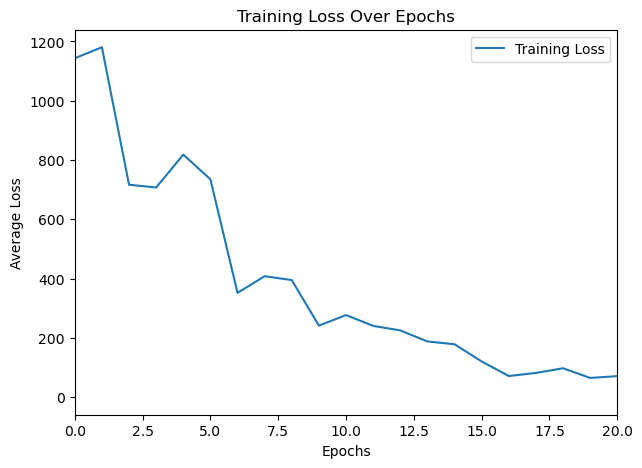

In [134]:
x_trainScaled = torch.tensor(x_trainScaled)
y_trainScaled = torch.tensor(y_trainScaled)

train_data = customDataset(x_trainScaled.float(), y_trainScaled.float())

model = ANNCustomRegressionClass()
optimiser = CustomOptimizer(model.parameters(), 0.01)
model, losses = train_model(model, train_data, optimiser, meanSquaredError, 200, 64)
FinalLoss = []
for loss in losses:
  loss = loss.cpu().detach().numpy()
  FinalLoss.append(loss)
plt.figure(figsize=(7,5))
plt.plot(FinalLoss, label='Training Loss')
plt.title("Training Loss Over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Average Loss")
plt.xlim(0,20)
plt.legend()
plt.show()

In [135]:
x_testScaled = torch.tensor(x_testScaled)
y_testScaled = torch.tensor(y_testScaled)

test_data = customDataset(x_testScaled, y_testScaled)
y_true, y_pred = test_model(model, test_data, 32)

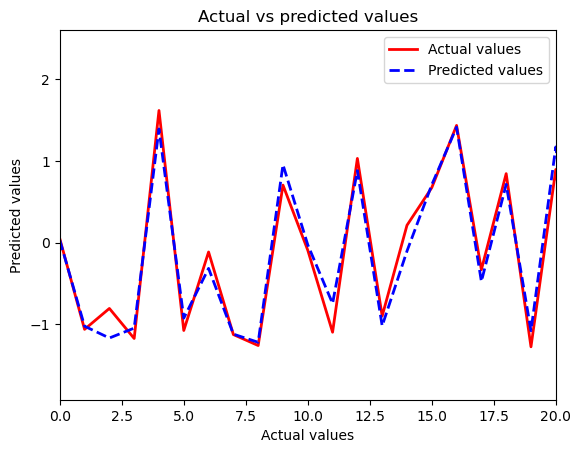

In [136]:
plt.xlim(0,20)
plt.plot(y_true, color='red', label='Actual (y_true)', linewidth=2)
plt.plot(y_pred, color='blue', label='Predicted (y_pred)', linewidth=2, linestyle='dashed')
plt.title('Actual vs predicted values')
plt.xlabel('Actual values')
plt.ylabel('Predicted values')
plt.legend(['Actual values', 'Predicted values'])
plt.show()

<BarContainer object of 2 artists>

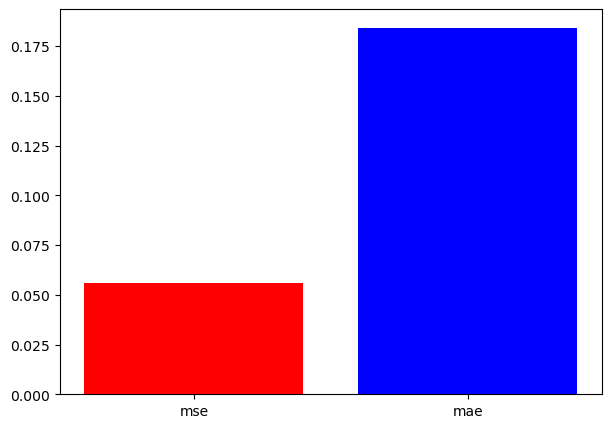

In [137]:
mse = mean_squared_error(y_true, y_pred)
mae = mean_absolute_error(y_true, y_pred)
plt.figure(figsize=(7,5))
plt.bar(['mse','mae'],[mse,mae] , color=['red','blue'])